In [172]:
# PREAMBLE
import pandas as pd
%matplotlib inline
import random
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
import re
import io
import os.path
plt.figure(figsize=(16*2, 9*2))

In [173]:
### Network I/O

In [174]:
# PROCESS SAR METRICS
FIND_ETH0 = re.compile(".+ eth0 .+")
FIND_CPU = re.compile(".+ all .+")
BW_COLS = ["ts", "rxpck","txpck","rxkB","txkB"]
CPU_COLS = ["cpu"]
SAMPLES = 5

network_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_ETH0.match, open(fname)))), header=None)\
                             .loc[:,[0,3,4,5,6]]
cpu_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_CPU.match, open(fname)))), header=None)\
                             .loc[:,[8]]

async_no_ssl_networks = tuple(network_df(os.path.join("reports", "async_no_ssl_no_sse-network.{}.sar.txt".format(i)))
                              for i in range(1,6))
async_yes_ssl_networks = tuple(network_df(os.path.join("reports", "async_yes_ssl_no_sse-network.{}.sar.txt".format(i)))
                               for i in range(1,6))
async_yes_sse_networks = tuple(network_df(os.path.join("reports", "async_yes_ssl_yes_sse-network.{}.sar.txt".format(i)))
                               for i in range(1,6))

async_no_ssl_cpus = tuple(cpu_df(os.path.join("reports", "async_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in range(1, SAMPLES+1))
async_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports", "async_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(1, SAMPLES+1))
async_yes_sse_cpus = tuple(cpu_df(os.path.join("reports", "async_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(1, SAMPLES+1))

for df in async_no_ssl_networks + async_yes_sse_networks + async_yes_ssl_networks:
    df.columns = BW_COLS

for df in async_no_ssl_cpus + async_yes_sse_cpus + async_yes_ssl_cpus:
    df.columns = CPU_COLS

async_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_no_ssl_cpus, 1)})
async_no_ssl_cpu.df_name = "no_ssl_cpu"
async_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_ssl_cpus, 1)})
async_yes_ssl_cpu.df_name = "yes_ssl_cpu"
async_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_sse_cpus, 1)})
async_yes_sse_cpu.df_name = "yes_sse_cpu"

async_no_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_no_ssl_networks, 1)})
async_no_ssl_network.df_name = "no_ssl_network"
async_yes_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_yes_ssl_networks, 1)})
async_yes_ssl_network.df_name = "yes_ssl_network"
async_yes_sse_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_yes_sse_networks, 1)})
async_yes_sse_network.df_name = "yes_sse_network"

async_cpu = (async_no_ssl_cpu, async_yes_ssl_cpu, async_yes_sse_cpu)
async_network = (async_no_ssl_network, async_yes_ssl_network, async_yes_sse_network)

for df in async_cpu + async_network:
    df["sample_mean"] = df[list(map("s{}".format, range(1, SAMPLES+1)))].mean(1)

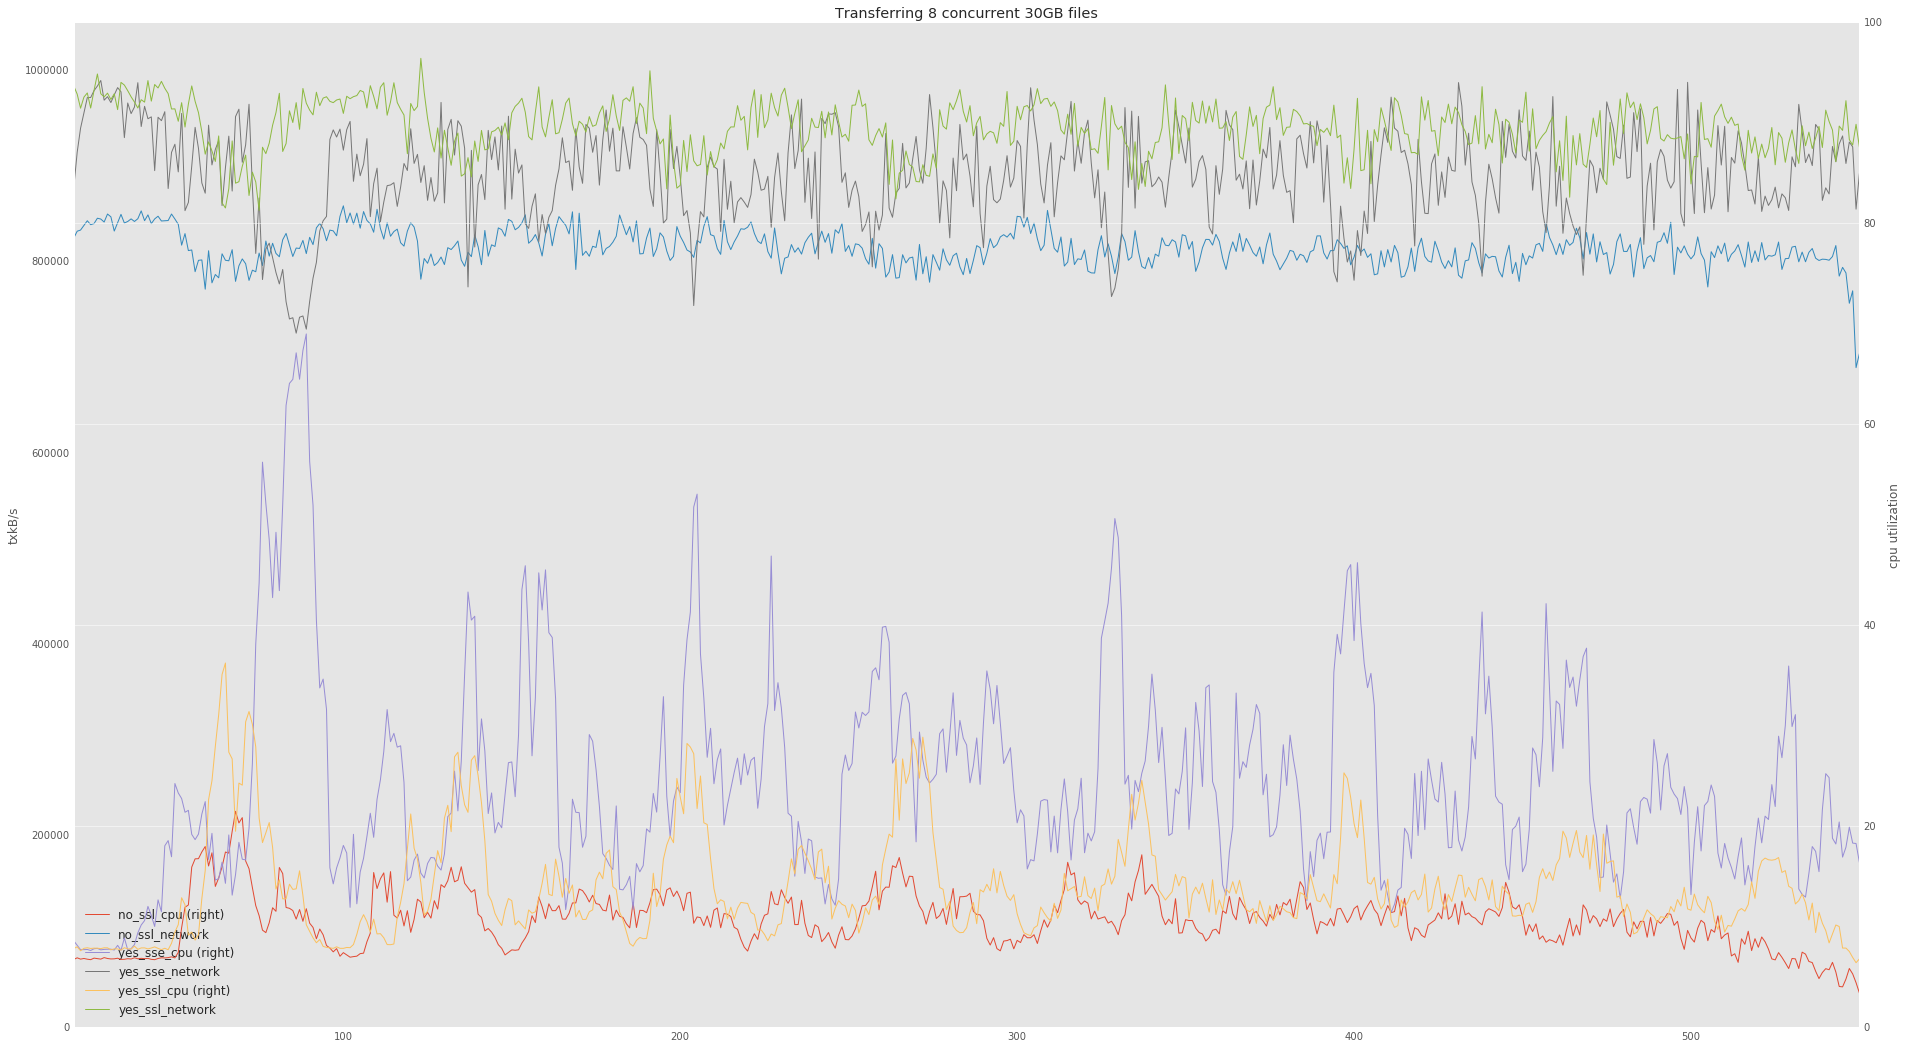

In [175]:
plt.figure()

summary = pd.DataFrame({df.df_name: df.sample_mean for df in async_cpu + async_network}).loc[20:550,]
summary_plt = summary.plot(
    secondary_y=[df.df_name for df in async_cpu], 
    mark_right=True,
    figsize=(16*2, 9*2)
)
summary_plt.set_ylabel("txkB/s")
summary_plt.set_ybound(0,1050000)
summary_plt.right_ax.set_ylabel("cpu utilization")
summary_plt.right_ax.set_ybound(0,100)
summary_plt.set_title("Transferring 8 concurrent 30GB files")

In [176]:
summary.mean()

no_ssl_cpu             10.666878
no_ssl_network     814318.018904
yes_sse_cpu            24.473209
yes_sse_network    891143.850384
yes_ssl_cpu            13.878154
yes_ssl_network    939537.549243
dtype: float64

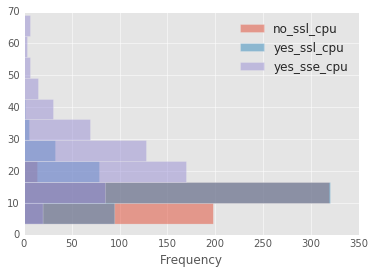

In [177]:
summary[[df.df_name for df in async_cpu]].plot.hist(
    stacked=False, 
    alpha=0.5,
    orientation='horizontal'
)

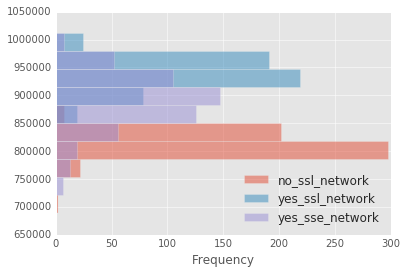

In [178]:
summary[[df.df_name for df in async_network]].plot.hist(
    stacked=False, 
    alpha=0.5,
    orientation='horizontal'
)

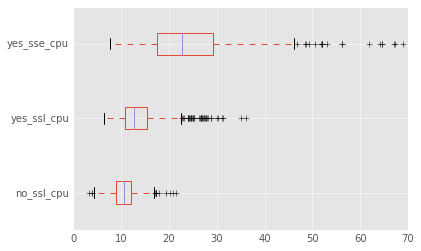

In [179]:
summary[[df.df_name for df in async_cpu]].plot.box(vert=False)

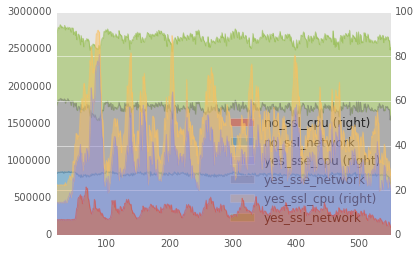

In [180]:
summary.plot.area(
    secondary_y=[df.df_name for df in async_cpu], 
    mark_right=True,
    alpha=.5,
    stacked=True
)

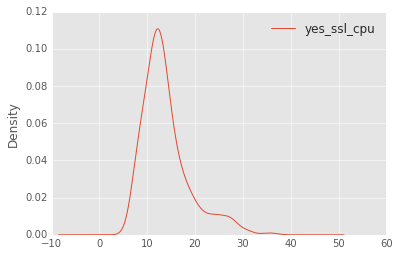

In [181]:
summary[["yes_ssl_cpu"]].plot.kde()

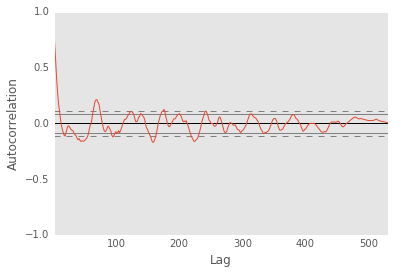

In [182]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(summary.yes_sse_cpu)

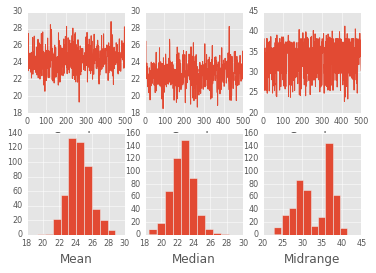

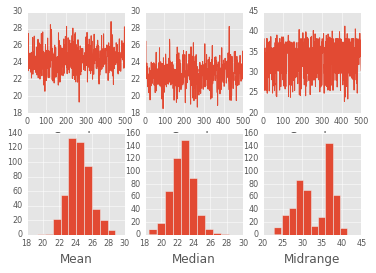

In [183]:
from pandas.tools.plotting import bootstrap_plot
bootstrap_plot(summary.yes_sse_cpu)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f05bfa36f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f05bf679668>], dtype=object)

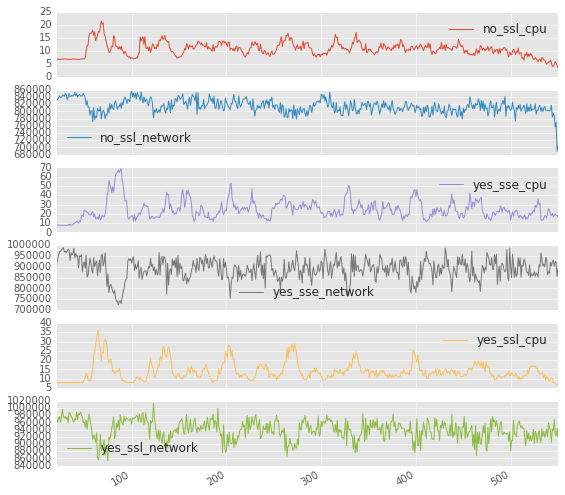

In [184]:
summary.plot(subplots=True, figsize=(9,9))

In [185]:
# PROCESS SAR METRICS
SAMPLES=10

single_no_ssl_networks = tuple(network_df(os.path.join("reports", "single_no_ssl_no_sse-network.{}.sar.txt".format(i)))
                              for i in range(0, SAMPLES))
single_yes_ssl_networks = tuple(network_df(os.path.join("reports", "single_yes_ssl_no_sse-network.{}.sar.txt".format(i)))
                               for i in range(0, SAMPLES))
single_yes_sse_networks = tuple(network_df(os.path.join("reports", "single_yes_ssl_yes_sse-network.{}.sar.txt".format(i)))
                               for i in range(0, SAMPLES))

single_no_ssl_cpus = tuple(cpu_df(os.path.join("reports", "single_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in range(0, SAMPLES))
single_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports", "single_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(0, SAMPLES))
single_yes_sse_cpus = tuple(cpu_df(os.path.join("reports", "single_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(0, SAMPLES))

for df in single_no_ssl_networks + single_yes_sse_networks + single_yes_ssl_networks:
    df.columns = BW_COLS

for df in single_no_ssl_cpus + single_yes_sse_cpus + single_yes_ssl_cpus:
    df.columns = CPU_COLS

single_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_no_ssl_cpus)})
single_no_ssl_cpu.df_name = "no_ssl_cpu"
single_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_ssl_cpus)})
single_yes_ssl_cpu.df_name = "yes_ssl_cpu"
single_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_sse_cpus)})
single_yes_sse_cpu.df_name = "yes_sse_cpu"

single_no_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_no_ssl_networks)})
single_no_ssl_network.df_name = "no_ssl_network"
single_yes_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_yes_ssl_networks)})
single_yes_ssl_network.df_name = "yes_ssl_network"
single_yes_sse_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_yes_sse_networks)})
single_yes_sse_network.df_name = "yes_sse_network"

single_cpu = (single_no_ssl_cpu, single_yes_ssl_cpu, single_yes_sse_cpu)
single_network = (single_no_ssl_network, single_yes_ssl_network, single_yes_sse_network)

for df in single_cpu + single_network:
    df["sample_mean"] = df[list(map("s{}".format, range(0, SAMPLES)))].mean(1)

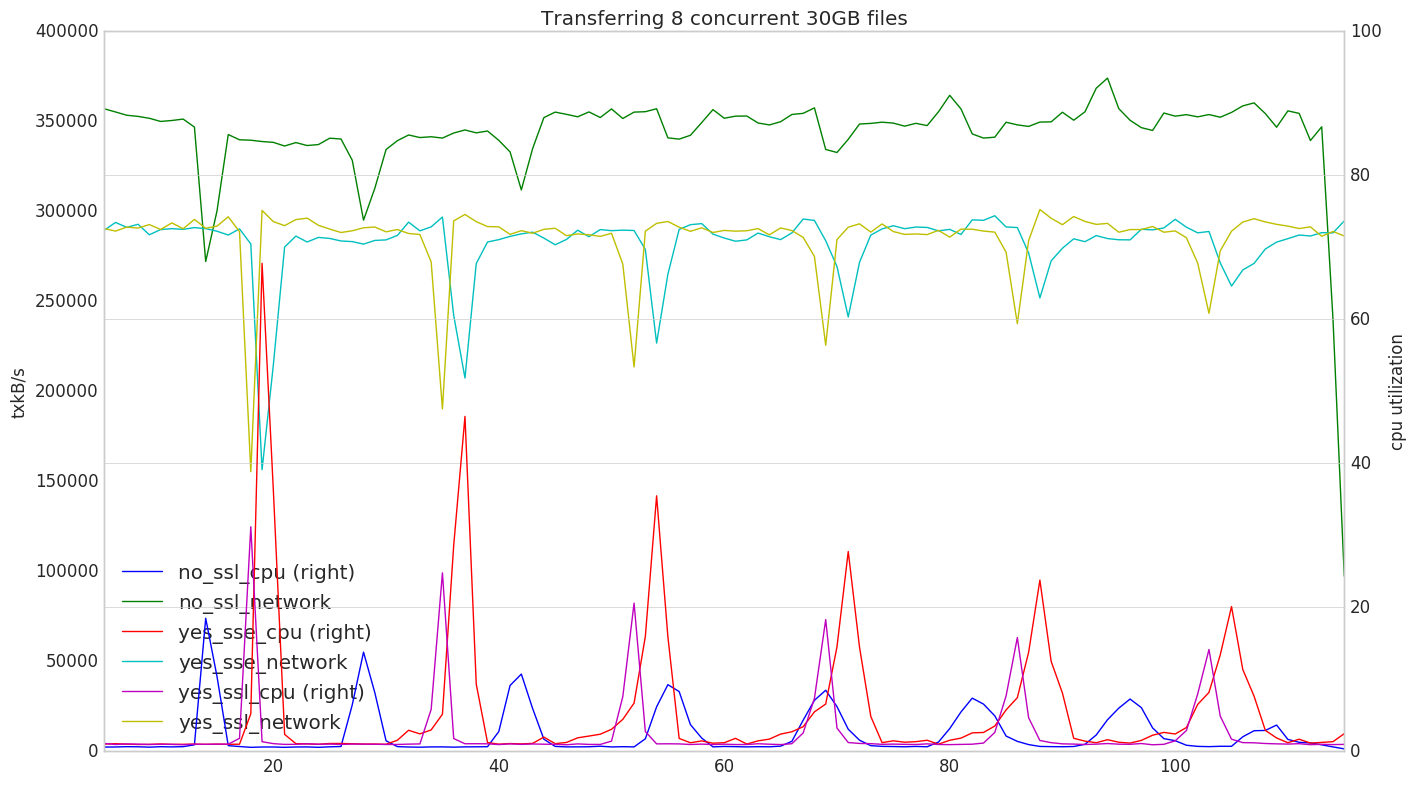

In [204]:
plt.figure()

single_summary = pd.DataFrame({df.df_name: df.sample_mean for df in single_cpu + single_network}).loc[5:115,]
single_summary_plt = single_summary.plot(
    secondary_y=[df.df_name for df in single_cpu], 
    mark_right=True,
    figsize=(16, 9)
)
single_summary_plt.set_ybound(0,400000)
single_summary_plt.set_ylabel("txkB/s")
single_summary_plt.right_ax.set_ylabel("cpu utilization")
single_summary_plt.right_ax.set_ybound(0,100)
single_summary_plt.set_title("Transferring 8 concurrent 30GB files")

In [188]:
single_summary.mean()

no_ssl_cpu              2.488503
no_ssl_network     342941.868024
yes_sse_cpu             5.588577
yes_sse_network    282063.833378
yes_ssl_cpu             2.559694
yes_ssl_network    285457.447703
dtype: float64

### Disk I/O

In [189]:
samples = []
for dev in ("eph-p", "eph-e", "io-e", "io-p"): #"gpt-e", 
    with open(os.path.join("reports", "bonnie.{}.txt".format(dev)), "r") as f:
        samples.extend(dev.split("-") + l.strip().split(",") for l in f.readlines()[1:])
#with open("reports/bonnie.ephemeral0.txt".format(dev), "r") as f:
#    samples.extend(["eph","p"] + l.strip().split(",") for l in f.readlines()[1:])

In [190]:
bonnie = pd.DataFrame(samples)[[0,1,11, 12, 13,17, 18, 39, 40,]+list(range(42,50))]
bonnie.columns=["dev_type", "enc_flag", "put_block", "put_block_cpu", "rewrite", "get_block",
"get_block_cpu", "put_block_latency","rewrite_latency",
"get_block_latency","seeks_latency","seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency","ran_stat_latency","ran_del_latency"]
#df = bonnie[bonnie.dev_type == "io"][[ "dev_type", "enc_flag","put_block"]]
df = bonnie[[ "dev_type", "enc_flag","put_block", "get_block"]]
df[["put_block", "get_block"]] = df[["put_block","get_block"]].apply(lambda x: pd.to_numeric(x, errors='coerce'))

/home/psoutham/.apps/anaconda3/envs/aws-encryption/lib/python3.5/site-packages/pandas/core/frame.py:2369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f05c0142390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f05c08d12b0>], dtype=object)

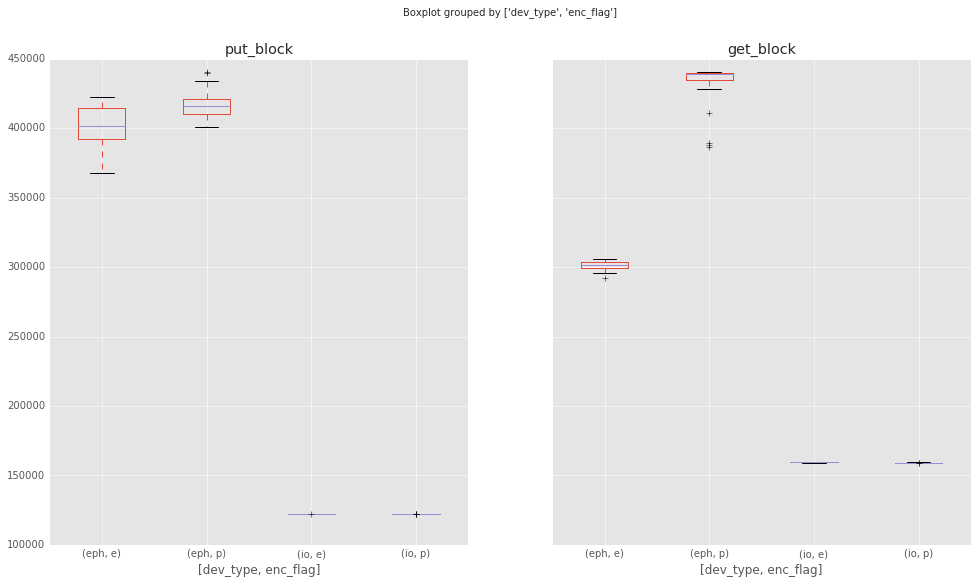

In [191]:
df.boxplot(by=["dev_type", "enc_flag"], 
           column=["put_block", "get_block"], 
           figsize=(16,9))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f05bf8954a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f05bf973c88>], dtype=object)

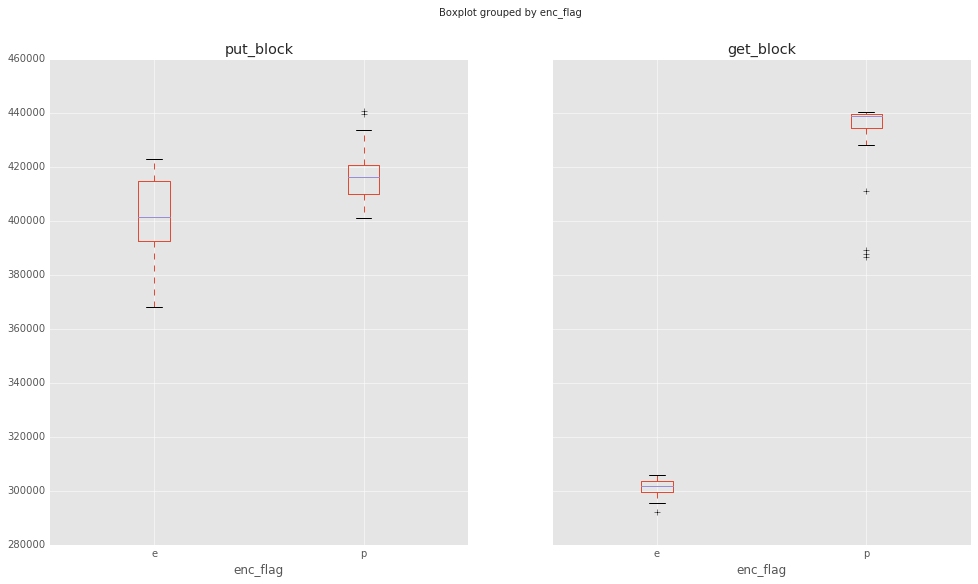

In [192]:
df[df.dev_type == "eph"].boxplot(by="enc_flag", 
           column=["put_block", "get_block"],           
           figsize=(16,9))

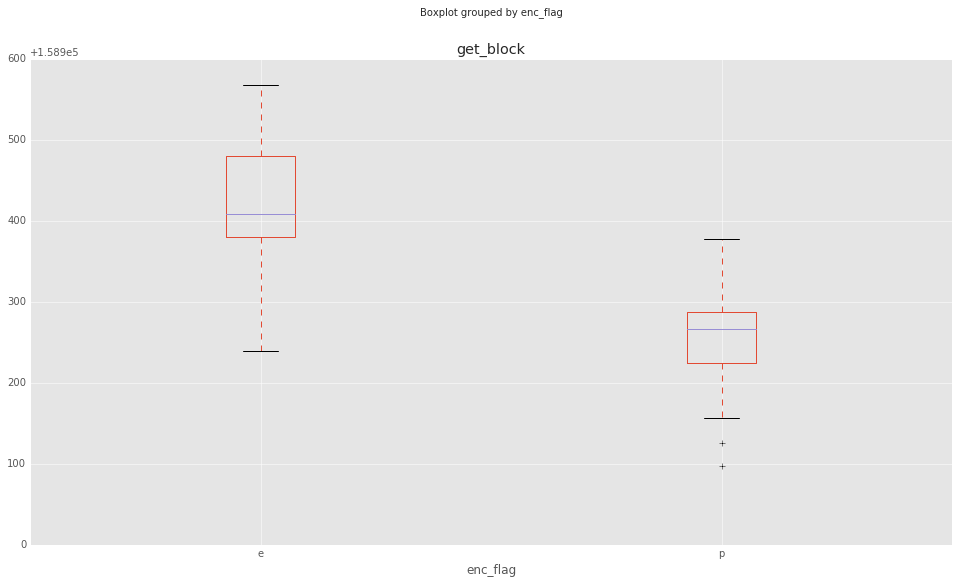

In [193]:
df[df.dev_type == "io"].boxplot(by="enc_flag", 
           column="get_block",           
           figsize=(16,9))

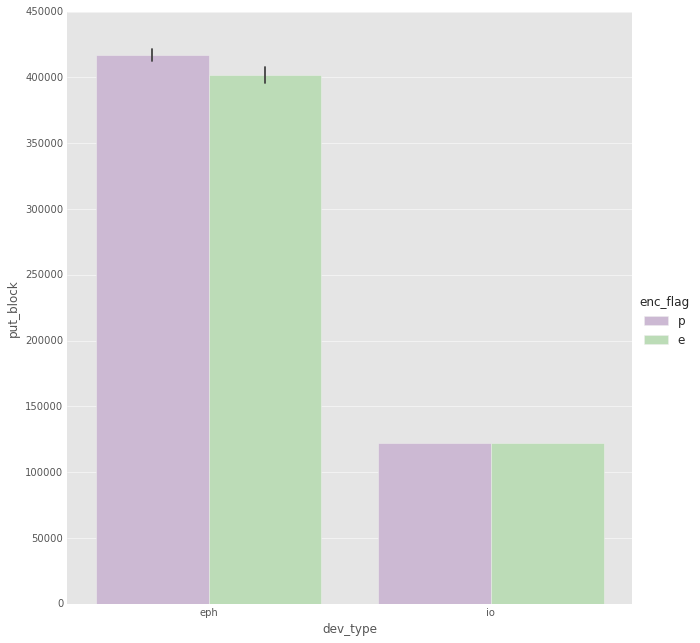

In [194]:
g = sns.factorplot(x="dev_type", y="put_block", hue="enc_flag", data=df,
                  kind="bar", size=9,palette="PRGn")
g.despine(left=True)

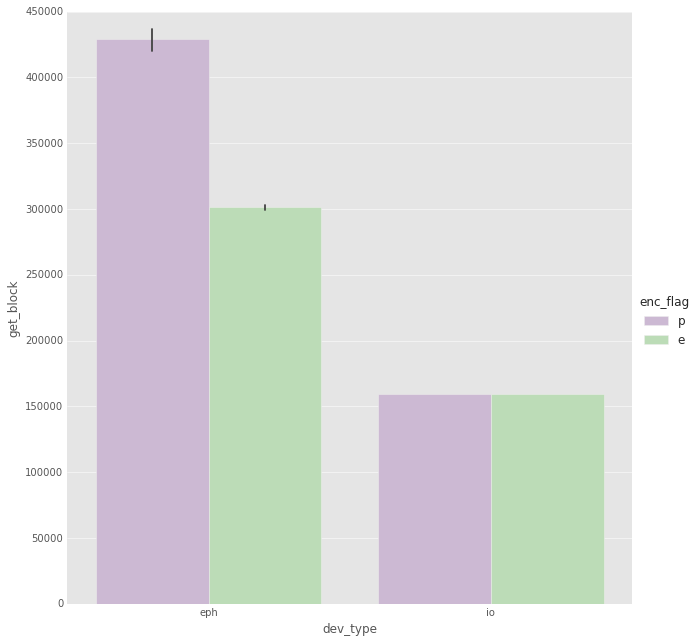

In [195]:
g = sns.factorplot(x="dev_type", y="get_block", hue="enc_flag", data=df,
                  kind="bar", size=9,palette="PRGn")
g.despine(left=True)

In [197]:
dfb = bonnie[[ "dev_type", "enc_flag","put_block_cpu", "get_block_cpu"]]
dfb[["put_block_cpu", "get_block_cpu"]] = dfb[["put_block_cpu","get_block_cpu"]].apply(lambda x: pd.to_numeric(x, errors='coerce'))

/home/psoutham/.apps/anaconda3/envs/aws-encryption/lib/python3.5/site-packages/pandas/core/frame.py:2369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


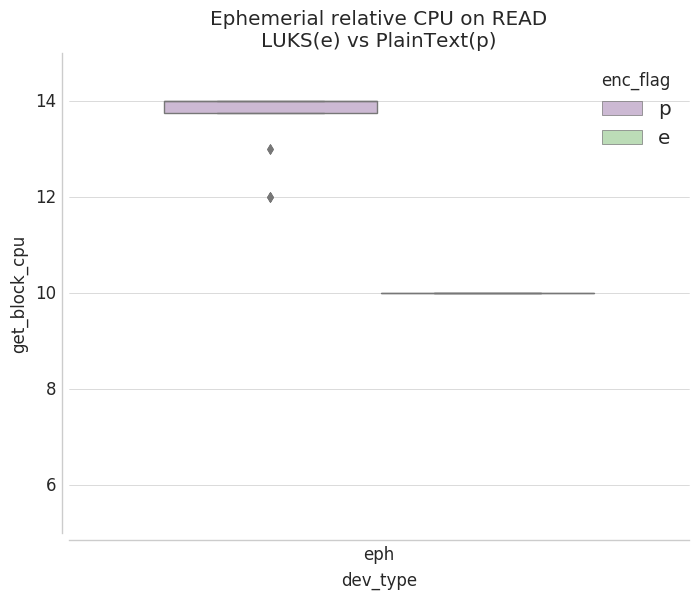

In [198]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="get_block_cpu", hue="enc_flag", data=dfb[dfb.dev_type == "eph"],palette="PRGn",width=.7)
g.set_title("Ephemerial relative CPU on READ\nLUKS(e) vs PlainText(p)")
g.set_ybound(5,15)
sns.despine(offset=5)

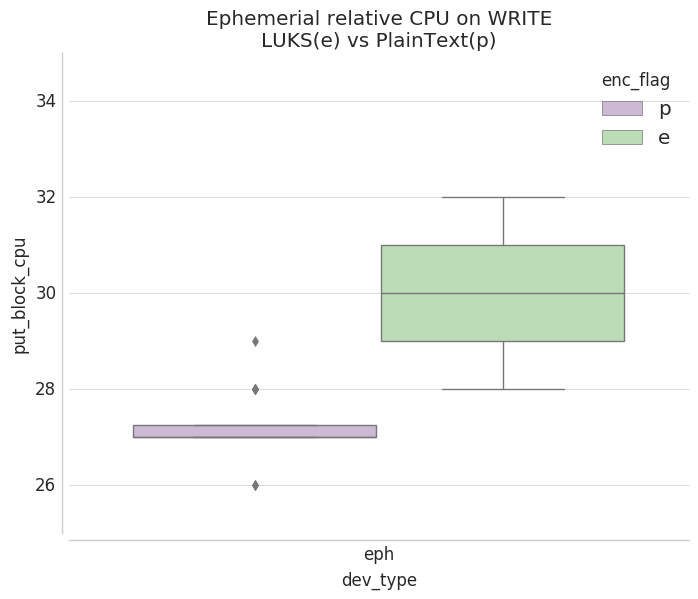

In [199]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="put_block_cpu", hue="enc_flag", data=dfb[dfb.dev_type == "eph"],palette="PRGn", width=.8)
g.set_title("Ephemerial relative CPU on WRITE\nLUKS(e) vs PlainText(p)")
g.set_ybound(25,35)
sns.despine(offset=5)

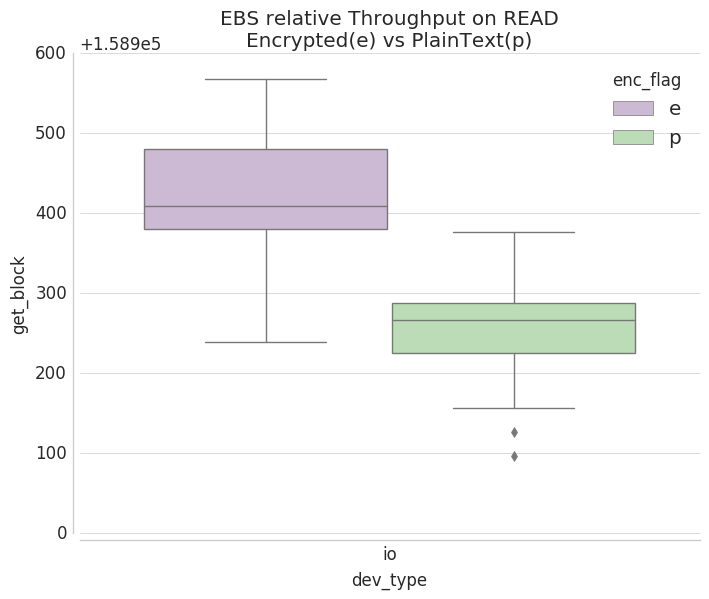

In [200]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="get_block", hue="enc_flag", data=df[df.dev_type == "io"],palette="PRGn", width=.8)
g.set_title("EBS relative Throughput on READ\nEncrypted(e) vs PlainText(p)")
sns.despine(offset=5)

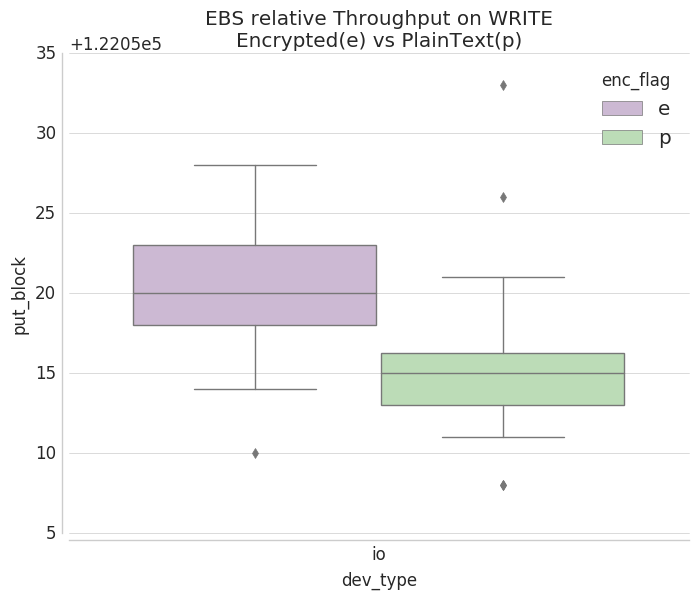

In [201]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="put_block", hue="enc_flag", data=df[df.dev_type == "io"],palette="PRGn", width=.8)
g.set_title("EBS relative Throughput on WRITE\nEncrypted(e) vs PlainText(p)")
sns.despine(offset=5)

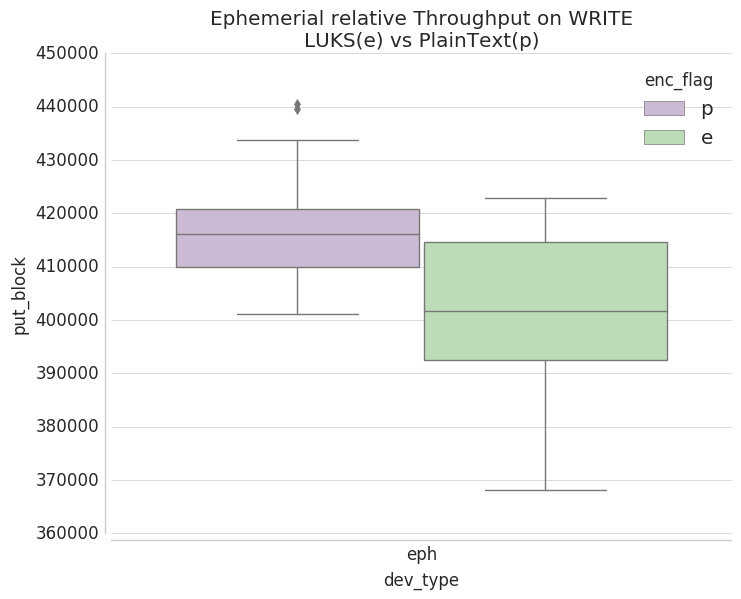

In [202]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="put_block", hue="enc_flag", data=df[df.dev_type == "eph"],palette="PRGn", width=.8)
g.set_title("Ephemerial relative Throughput on WRITE\nLUKS(e) vs PlainText(p)")
sns.despine(offset=5)

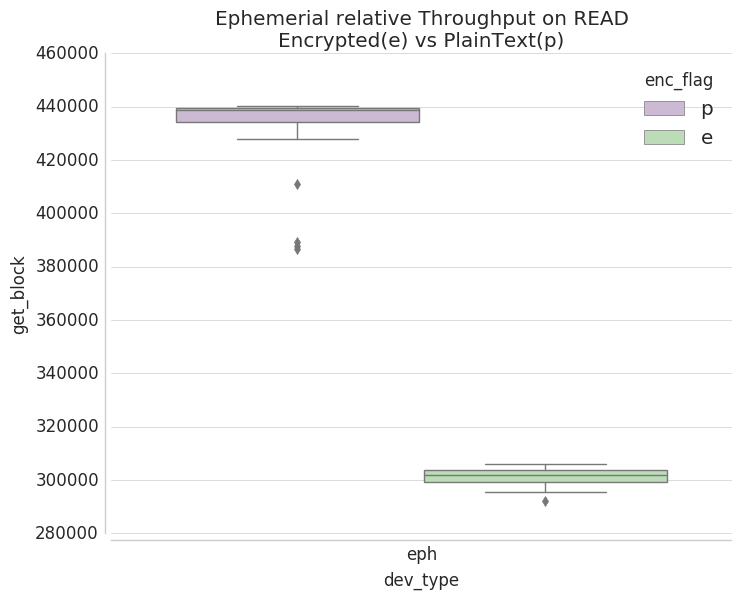

In [203]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="get_block", hue="enc_flag", data=df[df.dev_type == "eph"],palette="PRGn", width=.8)
g.set_title("Ephemerial relative Throughput on READ\nEncrypted(e) vs PlainText(p)")
sns.despine(offset=5)